# Section 7

In [1]:
using Plots
gr()
using LaTeXStrings

In [2]:
#using Revise
using SparseIR

## Generate IR basis by singular value expansion

In [3]:
# Create kenerl for lambda_ = 100 and beta = 10
# The default value of eps ``cutoff for singular values" is
# set to 2.2e-16.
# In this sample, we compute fewer basis functions.
lambda_ = 100
beta = 10
wmax = lambda_/beta
basis = FiniteTempBasis(fermion, beta, wmax, 1e-10)

FiniteTempBasis{LogisticKernel, Float64}(fermion, 10.0, 10.0)

## Fitting $\rho(\omega)$

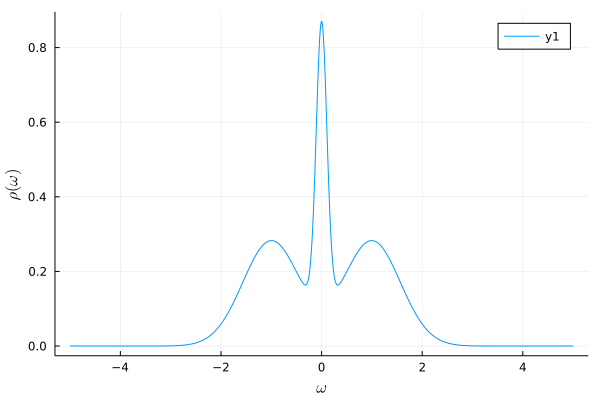

In [4]:
# Three Gaussian peaks (normalized to 1)
gaussian(x, mu, sigma) = exp.(-((x.-mu)/sigma).^2)/(sqrt(π)*sigma)

rho(omega) = 0.2*gaussian(omega, 0.0, 0.15) + 
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = collect(range(-5, 5, length=1000))
plot(omegas, rho(omegas), xlabel=latexstring("\\omega"), yaxis=latexstring("\\rho(\\omega)"))

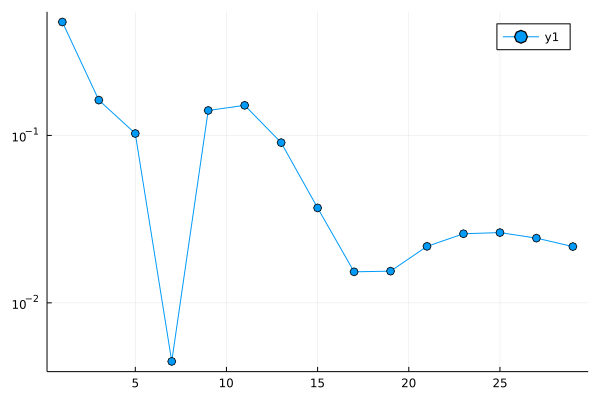

In [5]:
rhol = overlap(basis.v, rho)
plot(1:2:length(basis.s), abs.(rhol[1:2:end]), marker=:o, yaxis=:log)

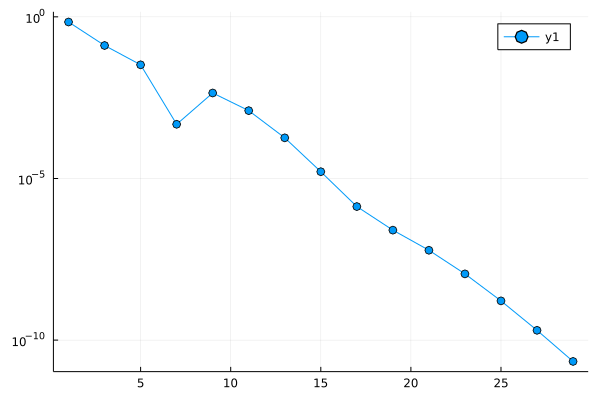

In [6]:
gl = -basis.s .* rhol
plot(1:2:length(basis.s), abs.(gl[1:2:end]), marker=:o, yaxis=:log)

## From IR to $\tau$

In [7]:
function eval_gtau(taus)
    uval = basis.u(taus)
    return transpose(uval) * gl
end

eval_gtau (generic function with 1 method)

In [8]:
taus = collect(range(0, beta, length=1000))
uval = basis.u(taus)
gtaus = transpose(uval) * gl
plt.plot(taus, gtaus)
plt.xlabel(L"$\tau$")
plt.ylabel(L"$G(\tau)$")

LoadError: UndefVarError: plt not defined

## Reconstruct $g_l$ by numerical integration

$$
g_l = \int_0^\beta d\tau U_l(\tau) G(\tau)
$$

In [ ]:
gl_reconst = overlap(basis.u, eval_gtau)

30-element Vector{Float64}:
 -0.6920636785861994
  1.431146867680866e-17
  0.12981384456200626
  1.2706849461530112e-16
  0.03278400482491757
  2.5982905063615114e-16
  0.0004749125996029724
  6.049848122469115e-17
 -0.004408753068412065
 -1.1861171766991419e-16
  0.0012537233549278744
 -4.423544863740858e-17
 -0.00018077145487143623
  ⋮
  2.523468063150673e-7
 -3.7556763254897874e-16
 -6.023717460685446e-8
 -2.3071822230491534e-16
  1.1190884509001964e-8
 -5.728924279413405e-16
 -1.6360674809823457e-9
 -1.7729416025569211e-15
  2.0110634869636296e-10
 -2.64328489651966e-15
 -2.192634309251644e-11
 -2.7720881146109377e-15

## Reconstruct $g_l$ by sparse sampling (fitting)

In [ ]:
smpl = TauSampling(basis)
println("Sampling points: ", smpl.sampling_points)
println("Condition number: ", SparseIR.cond(smpl))
gl_reconst_sparse = fit(smpl, eval_gtau(smpl.sampling_points))

Sampling points: [0.01254037513048938, 0.02508075026097876, 0.08460840508177567, 0.1796989521185004, 0.312470024897933, 0.48595940778421687, 0.7042195121916683, 0.9723734269596163, 1.2965285469576593, 1.6833693532954892, 2.1391650644818636, 2.667911987849984, 3.2685564079720226, 3.931899929399785, 4.638747103121012, 5.361252896878988, 6.068100070600215, 6.731443592027977, 7.332088012150016, 7.860834935518137, 8.31663064670451, 8.70347145304234, 9.027626573040385, 9.295780487808328, 9.514040592215782, 9.687529975102066, 9.820301047881497, 9.915391594918226, 9.97491924973902, 9.98745962486951]
Condition number: 5.8977021711722895


30-element Vector{Float64}:
 -0.6920636785861995
  6.521712125254791e-19
  0.12981384456200612
  1.4081346020139725e-17
  0.03278400482491736
 -1.888497810129382e-18
  0.00047491259960267515
 -3.600724414110954e-17
 -0.004408753068411993
  3.0838732831650207e-18
  0.0012537233549280017
  1.7090464827446165e-17
 -0.00018077145487160865
  ⋮
  2.52346806866384e-7
  3.572987638125455e-17
 -6.023717435704163e-8
 -6.6349663761813845e-18
  1.1190884842384988e-8
 -1.8413408762718104e-17
 -1.6360664731421147e-9
 -5.153497708897147e-18
  2.0110878835660045e-10
  1.0364731350582256e-17
 -2.1923543145074746e-11
  8.564542883853946e-18

## Comparison

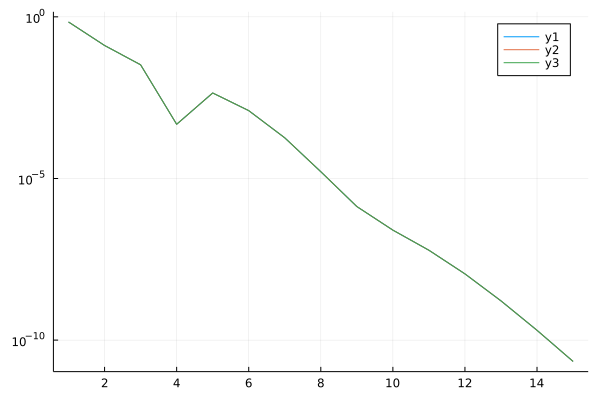

In [ ]:
gl = -basis.s .* rhol
plot([abs.(gl[1:2:end]), abs.(gl_reconst[1:2:end]), abs.(gl_reconst_sparse[1:2:end])], yaxis=:log)

## Sparse sampling in Matsubara

Sampling frequencies: [-229, -217, -93, -55, -39, -29, -23, -17, -15, -13, -11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15, 17, 23, 29, 39, 55, 93, 217, 229]
Condition number: 11.266380245503298


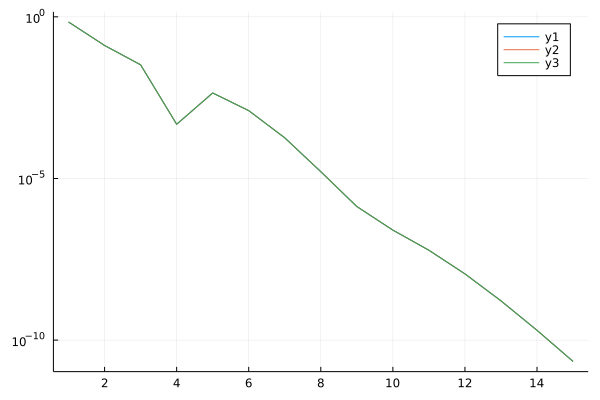

In [ ]:
function eval_giv(v)
    uhat_val = basis.uhat(v)
    return transpose(uhat_val) * gl
end

smpl_matsu = MatsubaraSampling(basis)
println("Sampling frequencies: ", smpl_matsu.sampling_points)
println("Condition number: ", SparseIR.cond(smpl_matsu))
gl_reconst_sparse_matsu = fit(smpl_matsu, eval_giv(smpl_matsu.sampling_points))

plot([abs.(gl[1:2:end]), abs.(gl_reconst_sparse[1:2:end]), abs.(gl_reconst_sparse_matsu[1:2:end])], yaxis=:log)